# GraphSAGE 的简单实现

主流图算法大致分两种：

- 图嵌入算法 (GE): DeepWalk, Node2Vec 等
- 图神经网络算法 (GNN): GraphSAGE, GCN, GAT 等

## 1. 绪论：图神经网络

图神经网络的输入一般是 **节点关联数据** 和 **节点特征数据**，输出是图嵌入。图神经网络算法做的事情，相当于将一种复杂的数据结构，转换成低维向量。低维向量往往是很好用的。

拿到图嵌入，我们可以做很多事情，比如：

- 节点分类
- 链接预测
- 社区发现
- 相似度量

总之，图嵌入是一种很有用的特征。图嵌入甚至可以和其他特征融合，训更复杂的模型。

### 1.1 GNN 和 CNN

GNN 似乎和 CNN 用了相同的思路。GNN 就像是 CNN 在图这种数据结构上的推广，我个人是这么感觉的。

我们说，CNN 有平移不变性和局部性。其中 **局部性** 是指：每个神经元只看一小块像素，但随着神经元在层数上堆叠，层级越高的神经元，“看到”的像素数量越多（如下图）。

![](./img/partial.svg)

假设 $C_1$ 能看见 4 个像素，$C_2$ 也能看见 4 个像素。由于 $B_1$ 能看见 $C_1$ 和 $C_2$，所以相当于 $B_1$ 能够“看见” `4*2=8` 个像素。

依此类推，$A$ 能看见 $B_1$ 和 $B_2$，相当于能“看见” `8*2=16` 个像素。

层级越高的神经元，底下的“小弟”越多。尽管每个小弟只负责看一小部分，但是高层级的神经元汇总了小弟们看见的部分，因此能够看到全局。这好比 merge 周报的老板，虽然每个细节知道的都不如员工多，但比员工更了解公司的全貌。

### 1.2 Aggregate 操作

图神经网络算法也有和 CNN 类似的汇聚过程。图神经网络会执行叫 Aggregate 的操作。虽然每次 Aggregate 只是把邻居节点的特征聚合到自己身上。但随着聚合次数增加，四跳五跳甚至十八跳节点的信息，也会一步一步“挪”过来。

更牛的是，Aggregate 是并行的。这意味着每轮迭代，所有节点都会收集邻居节点的信息。所有的节点，都会构建一个属于自己的深度网络。而且随着迭代轮次增加，网络的深度和范围也同步增加。

> 迭代次数与聚合范围的关系：
> 
> - 迭代第 1 个轮次，将 1 跳之内的节点信息聚合到本节点
> - 迭代第 2 个轮次，将 2 跳之内的节点信息聚合到本节点
> - ... ...
> - 迭代第 n 个轮次，将 n 跳之内的节点信息聚合到本节点

## 2. GraphSAGE 的基本思想

GraphSAGE 是一种可实时计算图嵌入的算法。这意味着它不需要知道节点所在的整张图的信息，只需要知道某节点 n 跳之内的拓扑关系和节点特征，就能计算该节点的嵌入。

它是如何做到这一点的呢？

GraphSAGE 的基本思想：不学节点的下标，而学节点的特征

比如，我们的节点有四项特征，分别表示一个同学是否喜欢唱跳rap篮球。我们只需要知道邻接的是一个喜欢唱跳rap篮球的人就好了，至于这个人是谁，我们并不关心。

|姓名|唱歌|跳舞|Rap|打篮球|
| -- | -- | -- | -- | -- |
|小真|1|1|1|1|
|小弥|1|1|1|1|
|小鲲|1|1|1|0|


## 3. GraphSAGE 的简单实现

> 在论文作者提供的 [简单版 GraphSAGE](https://github.com/williamleif/graphsage-simple) 之上进行改写，做了逐行注释、loss 可视化，并对部分代码细节进行优化。

### 3.1 Cora 数据集

[Cora 数据集](https://paperswithcode.com/dataset/cora) 是一个经典的图数据集。论文作者也是用此数据集作为示例。

> 具体来说，Cora 数据集是一个论文引用关系数据集。它由 2708 篇科学论文组成。这些论文被分成 7 个类别，类别包括神经网络、强化学习、规则学习等。每篇论文由一个 1433 维的词向量表示，该向量的每一个元素对应一个词，元素值为 0 或 1，表示该词在论文中的存在与否。所有词均来自一个有 1433 个词的字典。

Cora 数据集包含两个数据文件：

- `cora.content`：记录论文的编号、特征和类别标签。共 2708 行，每行代表一篇论文
- `cora.cites`：记录论文间的引用关系。共 5429 行，每行包含两个论文编号，表示一条引用关系

### 3.2 逐行注释

论文代码中，包含以下三个类：

|class|说明|
| -- | -- |
|`MeanAggregator`|聚合器，聚合邻居节点特征，相当于用邻居节点的表征来表示自己|
|`Encoder`|编码器，concat 当前节点的邻居特征和原始特征|
|`SupervisedGraphSage`|有监督学习器，用全连接层将嵌入结果 Embedding 与标号 label 连接，再用梯度下降更新 Embedding 以对齐 label |

这三个类很重要。你甚至可以只用这三个类，就把整个算法串出来。

1. 数据先流经 **MeanAggregator**，MeanAggregator 的作用是将邻居节点特征转换为本节点的表征。这里，把这种表征记作关联特征
2. 然后 **Encoder** 将关联特征与原始特征 concat 起来。concat 后的结果输入一个带 RuLU 的全连接层。这一步的输出其实已经是节点的 Embedding 了。只不过还要经过有监督学习的更新，才能保证 Embedding 具有分类性能
3. 监督学习 **SupervisedGraphSage** 为 Embedding 赋予分类性能。它用全连接层将 Embedding 和标号 label 连接起来。经过多轮训练，最终得到既包含节点特征信息，又包含关联信息，还对由 label 定义的类型具有良好分类性能的 Embedding


In [1]:
# 在 MacOS 上，尝试修复一个程序导入不同 OpenMP 的问题
# https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md
# import os
# os.environ['MKL_THREADING_LAYER'] = 'GNU'

In [2]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

import numpy as np
import time
import random

from sklearn.metrics import f1_score
from collections import defaultdict

In [3]:
class MeanAggregator(nn.Module):
    """
    Aggregates a node's embeddings using mean of neighbors' embeddings
    """
    def __init__(self, features, cuda=False, gcn=False): 
        """
        Initializes the aggregator for a specific graph.

        :param features: function mapping LongTensor of node ids to FloatTensor of feature values.
        :param cuda: whether to use GPU
        :param gcn: whether to perform concatenation GraphSAGE-style, or add self-loops GCN-style
        """

        super(MeanAggregator, self).__init__()

        self.features = features
        self.cuda = cuda
        self.gcn = gcn

    def forward(self, nodes, to_neighs, num_sample=10):
        """
        :param nodes: list of nodes in a batch
        :param to_neighs: list of sets, each set is the set of neighbors for node in batch
        :param num_sample: number of neighbors to sample. No sampling if None.
        """
        # Local pointers to functions (speed hack)
        _set = set
        if not num_sample is None:
            # 对批量内每一个 node 的邻居，抽 num_sample 个样本
            _sample = random.sample
            samp_neighs = [_set(_sample(list(to_neigh), 
                            num_sample,
                            )) if len(to_neigh) >= num_sample else to_neigh for to_neigh in to_neighs]
        else:
            samp_neighs = to_neighs

        if self.gcn:
            # 邻居节点 + 本节点
            samp_neighs = [samp_neigh + set([nodes[i]]) for i, samp_neigh in enumerate(samp_neighs)]
        unique_nodes_list = list(set.union(*samp_neighs))

        # 建一个字典，存节点到节点编码的映射
        unique_nodes = {n:i for i,n in enumerate(unique_nodes_list)}

        # mask 是一个全零矩阵，shape 是 (批量大小, 无重复的节点数)
        mask = Variable(torch.zeros(len(samp_neighs), len(unique_nodes)))

        # 把邻居列表摊平，并将每个邻居元素换成它对应的编码 i
        column_indices = [unique_nodes[n] for samp_neigh in samp_neighs for n in samp_neigh]   
        
        # 一个数列，长度是 节点数 * 节点邻居数，相当于每个邻居在数列中被其节点的编号表示
        row_indices = [i for i in range(len(samp_neighs)) for j in range(len(samp_neighs[i]))]
        
        # 一个稀疏矩阵，行表示节点，列表示邻居，节点与邻居之间有边的时候，对应矩阵元素值为 1
        mask[row_indices, column_indices] = 1
        if self.cuda:
            mask = mask.cuda()

        # 沿着 1 轴的方向（按行）求和，并保留维度
        num_neigh = mask.sum(1, keepdim=True)

        # 利用广播机制，求行平均
        mask = mask.div(num_neigh)

        # self.features 是将节点 id 转换为 节点特征的函数
        if self.cuda:
            embed_matrix = self.features(torch.LongTensor(unique_nodes_list).cuda())
        else:
            embed_matrix = self.features(torch.LongTensor(unique_nodes_list))

        # 矩阵乘法 (节点个数, 所有邻居节点个数) @ (所有邻居节点个数, 特征维数) => （节点个数, 特征维数）
        to_feats = mask.mm(embed_matrix)

        return to_feats

In [4]:
class Encoder(nn.Module):
    """
    Encodes a node's using 'convolutional' GraphSage approach
    """
    def __init__(self, features, feature_dim, embed_dim,
                 adj_lists, aggregator, num_sample=10,
                 gcn=False, cuda=False):
        """初始化

        :param features: 特征矩阵
        :param feature_dim: 特征数
        :param embed_dim: 嵌入维度
        :param adj_lists: 节点间关联关系，被存成值为集合的字典
        :param aggregator: 聚合器，用于生成邻居节点的嵌入
        :param num_sample: 邻居节点抽样个数
        :param gcn: 是否仅使用关联信息
        :param cuda: 是否使用 cuda
        """
        super(Encoder, self).__init__()

        self.features = features
        self.feat_dim = feature_dim
        self.adj_lists = adj_lists
        self.aggregator = aggregator
        self.num_sample = num_sample

        self.gcn = gcn
        self.embed_dim = embed_dim
        self.cuda = cuda
        self.aggregator.cuda = cuda
        self.weight = nn.Parameter(
            torch.FloatTensor(embed_dim, self.feat_dim if self.gcn else 2 * self.feat_dim))
        init.xavier_uniform_(self.weight)  # 对权重做初始化

    def forward(self, nodes):
        """
        Generates embeddings for a batch of nodes.

        :param nodes: list of nodes
        """
        # 邻居特征
        neigh_feats = self.aggregator.forward(nodes, [self.adj_lists[int(node)] for node in nodes], self.num_sample)
        # 表格特征
        if not self.gcn:
            if self.cuda:
                self_feats = self.features(torch.LongTensor(nodes).cuda())
            else:
                self_feats = self.features(torch.LongTensor(nodes))
            # 将邻居特征和表格特征 concat 起来
            combined = torch.cat([self_feats, neigh_feats], dim=1)
        else:
            # 只有邻居特征
            combined = neigh_feats
        # 全连接层加一个 ReLU 激活函数
        combined = F.relu(self.weight.mm(combined.t()))
        return combined

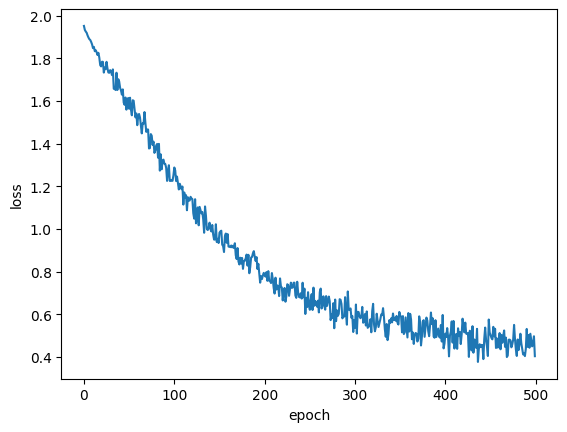

val_output.shape: torch.Size([500, 7])
Validation F1: 0.81
Average batch time: 0.020s
Loss: 0.403

Top 5 results:
229: y_true=0, y_pred=0
1569: y_true=1, y_pred=1
2029: y_true=0, y_pred=0
1294: y_true=3, y_pred=3
1498: y_true=6, y_pred=6

Embeding of first data:
index: 229
Embedding of 229: tensor([ 3.5384, -0.9888,  1.0722, -1.0584, -0.6644, -1.3325, -0.4637],
       grad_fn=<SelectBackward0>)
Shape of Embedding: torch.Size([7])


In [5]:
class SupervisedGraphSage(nn.Module):

    def __init__(self, num_classes, enc):
        super(SupervisedGraphSage, self).__init__()
        self.enc = enc
        self.xent = nn.CrossEntropyLoss()

        self.weight = nn.Parameter(torch.FloatTensor(num_classes, enc.embed_dim))
        init.xavier_uniform_(self.weight)

    def forward(self, nodes):
        # 获取节点的嵌入表示
        embeds = self.enc(nodes)
        # 全连接层
        scores = self.weight.mm(embeds)
        return scores.t()

    def loss(self, nodes, labels):
        scores = self.forward(nodes)
        return self.xent(scores, labels.squeeze())

def load_cora(num_nodes: int, num_feats: int):
    """加载 cora 数据集
 
    :param num_nodes: 节点数
    :param num_feats: 特征数
    """
    # 读入引用特征表
    feat_data = np.zeros((num_nodes, num_feats))  # 特征矩阵
    labels = np.empty((num_nodes, 1), dtype=np.int64)  # 引用分类标签

    node_map = {}  # 引用到特征在特征矩阵中行号的映射
    label_map = {}  # 真实标签值到标签编码的映射
    with open("data/cora.content") as fp:
        for i, line in enumerate(fp):
            info = line.strip().split()
            feat_data[i,:] = [float(e) for e in info[1:-1]]  # 将特征存入特征矩阵
            node_map[info[0]] = i  # 记录引用特征在特征矩阵中的行号
            if not info[-1] in label_map:
                label_map[info[-1]] = len(label_map)  # 标签编码
            labels[i] = label_map[info[-1]]  # 记录特征矩阵第 i 行的分类标签编码

    # 记录每个节点的邻居节点，邻居节点的集合存成 set
    adj_lists = defaultdict(set)
    with open("data/cora.cites") as fp:
        for line in fp:
            info = line.strip().split()

            # 将节点编号转换为特征矩阵的行号
            paper1 = node_map[info[0]]
            paper2 = node_map[info[1]]

            # 记录节点的邻居节点
            adj_lists[paper1].add(paper2)
            adj_lists[paper2].add(paper1)

    # 返回 特征矩阵 (feat_data), 特征对应标签 (labels), 关联关系 (adj_lists)
    return feat_data, labels, adj_lists

def num_gpus():
    """Get the number of available GPUs"""
    return torch.cuda.device_count()

def run_cora(epoch):
    np.random.seed(1)
    random.seed(1)

    # cuda 是否可用
    use_cuda = True if num_gpus() > 0 else False

    num_nodes = 2708  # 引用数
    num_feats = 1433  # 特征数
    feat_data, labels, adj_lists = load_cora(num_nodes=num_nodes,
                                             num_feats=num_feats)

    # 无重复的标签数
    label_cnt = len(set([e[0] for e in labels]))

    # 初始化 Embedding 和权重
    features = nn.Embedding(num_nodes, num_feats)
    features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad=False)
    if use_cuda:
        features.cuda()

    # 定义网络结构
    agg1 = MeanAggregator(features, cuda=use_cuda)
    enc1 = Encoder(features, num_feats, 128, adj_lists, agg1, gcn=True, cuda=use_cuda)
    agg2 = MeanAggregator(lambda nodes: enc1(nodes).t(), cuda=use_cuda)
    enc2 = Encoder(lambda nodes: enc1(nodes).t(), enc1.embed_dim, 128, adj_lists, agg2,
                   gcn=True, cuda=use_cuda)
    enc1.num_samples = 5
    enc2.num_samples = 5

    graphsage = SupervisedGraphSage(label_cnt, enc2)
    if use_cuda:
        graphsage.cuda()

    rand_indices = np.random.permutation(num_nodes)
    test = rand_indices[:1000]  # 测试集下标
    val = rand_indices[1000:1500]  # 验证集下标
    train = list(rand_indices[1500:])  # 训练集下标

    # 定义优化器
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, graphsage.parameters()), lr=0.7)

    times = []
    loss_list = []
    for batch in range(epoch):
        # 这里做了简化处理，把训练集的前 256 个元素做成一个批量
        # 且没有使用多个批量
        batch_nodes = train[:256]
        random.shuffle(train)

        # 开始时间
        start_time = time.time()

        # 清除上一轮次留下的梯度
        optimizer.zero_grad()

        # 计算 loss
        loss = graphsage.loss(batch_nodes,
                              Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
        # 反向传播
        loss.backward()
        
        # 用优化器更新网络权重
        optimizer.step()

        # 结束时间
        end_time = time.time()

        # 记录耗时和美轮结束时的损失值
        times.append(end_time - start_time)
        loss_list.append(loss.data.item())

    # 画图，可视化 loss 下降曲线
    plt.plot(loss_list)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

    # 对验证集做推理
    val_output = graphsage.forward(val)

    # 打印评估指标
    y_true = labels[val]
    y_pred = val_output.data.numpy().argmax(axis=1)
    print("val_output.shape:", val_output.shape)
    print("Validation F1:", f1_score(y_true, y_pred, average="micro"))
    print(f"Average batch time: {np.mean(times):.3f}s")
    print(f"Loss: {loss_list[-1]:.3f}")
    print()

    # 打印前 5 个推理结果
    print("Top 5 results:")
    for i in range(5):
        print(f'{val[i]}: y_true={y_true[i][0]}, y_pred={y_pred[i]}')
    print()

    # 打印第一个 Embedding
    print('Embeding of first data:')
    print(f'index: {val[0]}')
    print(f'Embedding of {val[0]}: {val_output[0]}')
    print(f'Shape of Embedding: {val_output[0].shape}')


run_cora(epoch=500)

参考：

- arXiv: [Inductive Representation Learning on Large Graphs](https://arxiv.org/pdf/1706.02216)
- GitHub:
  - [GraphSAGE](https://github.com/williamleif/GraphSAGE)
  - [graphsage-simple](https://github.com/williamleif/graphsage-simple)